# 0a - Merging of experiments & models into one file & analysing of initial states (area & volume) for different experiments, GCMs & models:

   
- merges all regional volume and area glacier runs of the different models into two netCDF filec
    - option A: non-postprocessed aggregated file `../data/GMIP3_reg_glacier_model_data/glacierMIP3_Feb12_2024_models_all_rgi_regions_sum.nc`
        - (interesting for testing, understanding the models workflow, or specific model intercomparison)
    - option B: volume/area scaling applied so that all models start at the exact same initial state (i.e., Farinotti et al. 2019 volume and RGI6 area): `../data/GMIP3_reg_glacier_model_data/glacierMIP3_Feb12_2024_models_all_rgi_regions_sum_scaled.nc`
- also plots amount of experiments per glacier model and checks initial state before having applied volume/area scaling
- these datasets also include OGGM_v153 and OGGM_VAS. These model options are not part of the first GlacierMIP3 study, but might be used for a study focusing on the glacier model differences. 
 

In [1]:
DATE = 'Feb12_2024'

In [2]:
# import some packages that we need later
import xarray as xr
import numpy as np
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import oggm
import geopandas as gpd

In [3]:
# Define experiments 
gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]
scenarios = ['hist', 'ssp126', 'ssp370', 'ssp585']
y0_times = [1851, 1901, 1951, 1995, 2021, 2041, 2061, 2081]

# get the RGI area / ITMIX volumes of the glaciers
rgi_regs = []
for rgi_reg in np.arange(1,20,1):
    if rgi_reg < 10:
        rgi_reg = '0'+str(rgi_reg)
    else:
        rgi_reg = str(rgi_reg)
    rgi_regs.append(rgi_reg)
df_itmix = pd.read_hdf(oggm.utils.get_demo_file('rgi62_itmix_df.h5'))

rgidf_dict = {}
for rgi_reg in rgi_regs:
    path_rgi = oggm.utils.get_rgi_region_file(rgi_reg, version='6')
    rgidf = gpd.read_file(path_rgi)
    # Greenland periphery : all glaciers with connectivity level 0 and 1 should be included,
    # level 2 glaciers should be excluded (as was the case for GlacierMIP2)
    # total RGI area: 89,651km2
    if rgi_reg == '05':
        rgidf = rgidf.loc[(rgidf['Connect'] == 0) | (rgidf['Connect'] ==1)]
    rgidf_dict[rgi_reg] = rgidf
    rgidf_dict[rgi_reg] = rgidf_dict[rgi_reg].set_index('RGIId')

path_rgi = oggm.utils.get_rgi_region_file('05', version='6')
rgidf = gpd.read_file(path_rgi)
rgidf_c = rgidf.loc[(rgidf['Connect'] == 0) | (rgidf['Connect'] ==1)]
n_excluded = len(rgidf) - len(rgidf_c)
print(f'amount of glaciers excluded in RGI region 05 because they are connectivity level 2: {n_excluded}')

amount of glaciers excluded in RGI region 05 because they are connectivity level 2: 955


In [6]:
df_itmix['vol_itmix_m3'].sum()

158156598389542.3

In [4]:
def get_path(folder_path='/home/www/lschuster/glacierMIP3_analysis',
             rgi_reg='01',
             model_author='PyGEM-OGGM_v13',
             period='1851-1870', gcm='gfdl-esm4', ssp='hist'):
    ''' output the regional simulation file path for the respective
    rgi_reg, model_author, period, gcm & ssp '''
    if (model_author == 'PyGEM-OGGM_v13'):
        model_author_file = 'Rounce'
        path = f'{folder_path}/{model_author}/regional-filled-norunaway/{rgi_reg}/{model_author_file}_rgi{rgi_reg}_sum_{period}_{gcm}_{ssp}.nc'
    elif ('OGGM' in model_author):
        # was corrected for missing glaciers ... (by Lilian Schuster with method of Fabien)
        model_author_f = model_author
        if 'OGGM' in model_author and ssp == 'hist':
            ssp = 'historical'
            path =  f'{folder_path}/{model_author_f}/regional_filled/{rgi_reg}/{model_author}_rgi{rgi_reg}_sum_{period}_{gcm}_{ssp}_filled.nc'
        else:
            path =  f'{folder_path}/{model_author_f}/regional_filled/{rgi_reg}/{model_author}_rgi{rgi_reg}_sum_{period}_{gcm}_{ssp}_filled.nc'
    else:
        if gcm=='ipsl-cm6a-lr':
            if model_author=='GloGEMflow':
                gcm='psl_cm6a-lr' # no 'i' and '_' instead of '-'
        if model_author=='Kraaijenbrink' or model_author=='GO':
            if ssp == 'hist':
                ssp='historical'
        if model_author == 'GloGEMflow3D':
            model_author_file = 'Zekollari'
            if ssp == 'hist':
                ssp = 'ssp126'
        else:
            model_author_file = model_author
        path = f'{folder_path}/{model_author}/{model_author_file}_rgi{rgi_reg}_sum_{period}_{gcm}_{ssp}.nc'
    return path

In [5]:
def scale_area_vol(ds, rgi_reg='01'):
    rgis = rgidf_dict[rgi_reg].index.values
    vol_scaling = df_itmix.loc[rgis]['vol_itmix_m3'].sum() / ds.volume_m3.isel(simulation_year=0)
    ds['volume_m3'] = ds.volume_m3 * vol_scaling
    area_scaling = (rgidf_dict[rgi_reg]['Area'].sum()*1e6) / ds.area_m2.isel(simulation_year=0)
    ds['area_m2'] = ds.area_m2 * area_scaling
    return ds

In [78]:
# we have here all inside, although we will later not look into OGGM_v153 and OGGM-VAS
model_authors = ['CISM2','GO', 'PyGEM-OGGM_v13','GloGEMflow','Kraaijenbrink','GLIMB',
                  'OGGM_v153','OGGM_v16', 'OGGM-VAS', 'GloGEMflow3D']

# We need dummy datasets, because some files only go until 2000 and have to be extended then in order to be merged with the other files 
# dummy dataset ... w. 5001 entries
ds_nan_5001 = xr.open_dataset(get_path(rgi_reg='01'))
ds_nan_5001.volume_m3.data[...] = np.NaN
ds_nan_5001.area_m2.data[...] = np.NaN

# dummy dataset ... w. 2001 entries
ds_nan_2001 = xr.open_dataset(get_path(rgi_reg='02')) 
ds_nan_2001.volume_m3.data[...] = np.NaN
ds_nan_2001.area_m2.data[...] = np.NaN


# these regions should run until 5000 years:
rgi_regs_5000 = ['01', '03', '04', '05', '06','07', '09', '17','19']

run = False# #True
if run:
    for apply_scaling in [False, True]:
        l_ds_list = []
        for model_author in model_authors: #['OGGM_v153']: #model_authors:
            print(model_author)
            missing_exp=[]
            _ds_reg = []
            for rgi_reg in rgi_regs: #'01'
                # want to have the right simulation year length
                _l_period = []
                for y0_time in y0_times[:4]:
                    period = f'{y0_time}-{y0_time+19}'
                    _l_scenario = []
                    for scenario in scenarios[:1]:
                        _l_gcm = []
                        for gcm in gcms:
                            path = get_path(rgi_reg=rgi_reg, model_author=model_author, period=period, gcm=gcm, ssp=scenario)
                            try:
                                if model_author == 'GloGEMflow' or model_author == 'Huss':
                                    _ds = xr.open_dataset(path)
                                    # wrong netcdf shape and simulation year 1 year too short ...
                                    if len(_ds.volume_m3.squeeze()) == 5000:
                                        ds = ds_nan_5001.copy(deep=True)
                                    elif len(_ds.volume_m3.squeeze()) == 2000:
                                        ds = ds_nan_2001.copy(deep=True)
                                    if model_author == 'Huss':
                                        ds.volume_m3.data[:-1] = _ds.volume_m3.squeeze() 
                                    else:
                                        ds.volume_m3.data[:-1] = _ds.volume_m3.squeeze()*1e9 # is in km3 instead of m3
                                    ds.area_m2.data[:-1] = _ds.area_m2.squeeze()
                                    # we will just fill up the last value with the second to the last value
                                    ds.volume_m3[-1] = ds.volume_m3[-2].values
                                    ds.area_m2[-1] = ds.area_m2[-2].values
                                    ds.attrs.update(_ds.attrs)
                                else:
                                    ds = xr.open_dataset(path)
                            except:
                                # in case of OGGM 11, went for 5000 yrs anyways
                                if rgi_reg in rgi_regs_5000:
                                    ds = ds_nan_5001.copy(deep=True)
                                else:
                                    ds = ds_nan_2001.copy(deep=True)
                                missing_exp.append(path)
                            if model_author == 'CISM2' and rgi_reg == '11':
                                ds.volume_m3.data = ds.volume_m3.squeeze()*1e9 # is in km3 instead of m3
                                ds.area_m2.data = ds.area_m2.squeeze()*1e6 # is in km3 instead of m3

                            ds = ds.reset_coords()[['volume_m3', 'area_m2']]
                            if apply_scaling:
                                ds = scale_area_vol(ds, rgi_reg = rgi_reg)
                            ds = ds.expand_dims({'gcm':[gcm], 'ssp':[scenario], 'period':[period], 'rgi_reg':[rgi_reg]})
                            _l_gcm.append(ds)
                        _l_scenario.append(xr.concat(_l_gcm, dim='gcm'))

                    _l_period.append(xr.concat(_l_scenario, dim='ssp'))
                ds_past = xr.concat(_l_period, dim='period')

                _l_period = []
                for y0_time in y0_times[4:]:
                    period = f'{y0_time}-{y0_time+19}'
                    _l_scenario = []
                    for scenario in scenarios[1:]:
                        _l_gcm = []
                        for gcm in gcms:
                            path = get_path(rgi_reg=rgi_reg, model_author=model_author, period=period, gcm=gcm, ssp=scenario)
                            try:
                                #if model_author == 'Compagno' and gcm=='ukesm1-0-ll' and rgi_reg == '05':
                                #    raise ValueError('duplicate values, fill with np.NaN')
                                if model_author == 'GloGEMflow' or model_author == 'Huss':
                                    _ds = xr.open_dataset(path)
                                    # wrong netcdf shape and simulation year 1 year too short ...
                                    if len(_ds.volume_m3.squeeze()) == 5000:
                                        ds = ds_nan_5001.copy(deep=True)
                                    elif len(_ds.volume_m3.squeeze()) == 2000:
                                        ds = ds_nan_2001.copy(deep=True)
                                    if model_author == 'Huss':
                                        ds.volume_m3.data[:-1] = _ds.volume_m3.squeeze() 
                                    else:
                                        ds.volume_m3.data[:-1] = _ds.volume_m3.squeeze()*1e9 # is in km3 instead of m3
                                    ds.area_m2.data[:-1] = _ds.area_m2.squeeze()
                                    ds.volume_m3[-1] = ds.volume_m3[-2].values
                                    ds.area_m2[-1] = ds.area_m2[-2].values
                                    ds.attrs.update(_ds.attrs)
                                else:
                                    ds = xr.open_dataset(path)
                            except:
                                if rgi_reg in rgi_regs_5000:
                                    ds = ds_nan_5001.copy(deep=True)
                                else:
                                    ds = ds_nan_2001.copy(deep=True)
                                missing_exp.append(path)
                            if model_author == 'CISM2' and rgi_reg == '11':
                                ds.volume_m3.data = ds.volume_m3.squeeze()*1e9 # is in km3 instead of m3
                                ds.area_m2.data = ds.area_m2.squeeze()*1e6 # is in km3 instead of m3
                            ds = ds.reset_coords()[['volume_m3', 'area_m2']]
                            if apply_scaling:
                                ds = scale_area_vol(ds, rgi_reg = rgi_reg)
                            ds = ds.expand_dims({'gcm':[gcm], 'ssp':[scenario], 'period':[period], 'rgi_reg':[rgi_reg]})
                            _l_gcm.append(ds)
                        _l_scenario.append(xr.concat(_l_gcm, dim='gcm'))
                    _l_period.append(xr.concat(_l_scenario, dim='ssp'))
                ds_future = xr.concat(_l_period, dim='period')
                _ds_reg_single = xr.concat([ds_past, ds_future], dim = 'ssp')
                # make sure that simulation_year is a coordinate
                _ds_reg_single.coords['simulation_year'] = _ds_reg_single.simulation_year
                _ds_reg.append(_ds_reg_single)
            ds = xr.concat(_ds_reg, dim='rgi_reg')

            _ds_mod = ds.expand_dims({'model_author':[model_author]})
            l_ds_list.append(_ds_mod)

        ds_reg_models = xr.concat(l_ds_list, dim='model_author')

        # This is the same for all files
        encoding = {
            'simulation_year': {"dtype": "int16"},
            'volume_m3': {"dtype": "float32"},
            'area_m2': {"dtype": "float32"},
        }

        ds_reg_models = ds_reg_models.stack(period_scenario = ('period', 'ssp'))
        ds_reg_models.coords['period_scenario'] = [a[0]+'_'+a[1] for a in ds_reg_models.period_scenario.values]

        l_period_ssp = ['1851-1870_hist', '1901-1920_hist', '1951-1970_hist',
           '1995-2014_hist',  '2021-2040_ssp126',
           '2021-2040_ssp370', '2021-2040_ssp585', 
           '2041-2060_ssp126', '2041-2060_ssp370', '2041-2060_ssp585',
           '2061-2080_ssp126', '2061-2080_ssp370',
           '2061-2080_ssp585', '2081-2100_ssp126',
           '2081-2100_ssp370', '2081-2100_ssp585']

        ds_reg_models = ds_reg_models.sel(period_scenario = l_period_ssp)

        if apply_scaling:
            out_path = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc'
            out_path2 = f'../data/GMIP3_reg_glacier_model_data/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc'
        else:
            out_path = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum.nc'
            out_path2 = f'../data/GMIP3_reg_glacier_model_data/glacierMIP3_{DATE}_models_all_rgi_regions_sum.nc'
    
        # put NaN into the duplicated file 
        #ds_reg_models.sel(model_author='Compagno').sel(rgi_reg='05').sel(gcm='ukesm1-0-ll').volume_m3.data[:,:] = np.NaN
        #ds_reg_models.sel(model_author='Compagno').sel(rgi_reg='05').sel(gcm='ukesm1-0-ll').area_m2.data[:,:] = np.NaN
                
        # remove 0 from RGI region 17 
        #ind_model_author = np.where((ds_reg_models.model_author=='Huss').to_dataframe().reset_index(drop=True))[0][0]
        #ind_rgi_reg = np.where((ds_reg_models.rgi_reg=='17').to_dataframe().reset_index(drop=True))[0][0]
        #ds_reg_models.volume_m3.data[ind_model_author,:,ind_rgi_reg, 2000:5001,:] = np.NaN
        ds_reg_models_sel = ds_reg_models.sel(rgi_reg='17')
        assert len(ds_reg_models_sel.sel(simulation_year=2000).volume_m3.where(ds_reg_models_sel.sel(simulation_year=2000).volume_m3==0).dropna(dim='model_author', how='all').model_author) == 0
        assert len(ds_reg_models_sel.sel(simulation_year=5000).volume_m3.where(ds_reg_models_sel.sel(simulation_year=5000).volume_m3==0).dropna(dim='model_author', how='all').model_author) == 0
        if not apply_scaling:
            ds_reg_models.attrs['description'] = 'Unprocessed regionally aggregated glacier model projections from GlacierMIP3 (volume and area).'
            ds_reg_models.attrs['postprocessing_phase'] = ('Unprocessed dataset with the "raw" regional files as submitted by the glacier model groups. '
                                        'Not used directly in any of the community estimate manuscript analysis, but '
                                        'of most interest for model comparison analyses. More in Supplementary Data Table 2 of Zekollari and Schuster et al., submitted') 
        else:
            ds_reg_models.attrs['description'] = 'Scaled regionally aggregated glacier model projections from GlacierMIP3 (volume and area).'
            ds_reg_models.attrs['postprocessing_phase'] = ('Volume scaled to match regional Farinotti et al. (2019) multi-model glacier volume estimate at the beginning, '
                                                            'area scaled to match the RGI6.0 area at the beginning. Scaling done for each climate scenario and model time '
                                                           'series (experiment) individually. For most experiments, scaling was not necessary as models aimed to match regional '
                                                           'volume/area, and upscaled already internally. More in Supplementary Data Table 2 of Zekollari and Schuster et al., submitted') 
        ds_reg_models.attrs['dataset_version'] = 'v1.0'
        ds_reg_models.attrs['source'] = 'Data from Glacier Model Intercomparison Project Phase 3 (GlacierMIP3), https://doi.org/10.5281/zenodo.14045269'
        ds_reg_models.attrs['contact'] = 'lilian.schuster@uibk.ac.at, harry.zekollari@vub.be'  
        ds_reg_models.to_netcdf(out_path, encoding = encoding)
        ds_reg_models.to_netcdf(out_path2, encoding = encoding)

else:
    out_path = f'../data/GMIP3_reg_glacier_model_data/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled.nc'

    ds_reg_models = xr.open_dataset(out_path)

In [34]:
ds_reg_models

<xarray.Dataset>
Dimensions:          (model_author: 10, simulation_year: 5001, gcm: 5,
                      rgi_reg: 19, period_scenario: 16)
Coordinates:
  * model_author     (model_author) <U14 'CISM2' 'GO' ... 'GloGEMflow3D'
  * simulation_year  (simulation_year) int16 0 1 2 3 4 ... 4997 4998 4999 5000
  * gcm              (gcm) <U13 'gfdl-esm4' 'ipsl-cm6a-lr' ... 'ukesm1-0-ll'
  * rgi_reg          (rgi_reg) <U2 '01' '02' '03' '04' ... '16' '17' '18' '19'
  * period_scenario  (period_scenario) <U16 '1851-1870_hist' ... '2081-2100_s...
Data variables:
    volume_m3        (model_author, gcm, rgi_reg, simulation_year, period_scenario) float32 ...
    area_m2          (model_author, gcm, rgi_reg, simulation_year, period_scenario) float32 ...
Attributes:
    description:           Scaled regionally aggregated glacier model project...
    postprocessing_phase:  Volume scaled to match regional Farinotti et al. (...
    dataset_version:       v1.0
    source:                Data from Glacier Model Intercomparison Project Ph...
    contact:               lilian.schuster@uibk.ac.at, harry.zekollari@vub.be

In [79]:
assert ds_reg_models.sel(model_author='CISM2').sel(rgi_reg='11').volume_m3.isel(simulation_year=0).std()/ds_reg_models.sel(model_author='CISM2').sel(rgi_reg='11').volume_m3.isel(simulation_year=0).max() < 1e-4

#### Rounding/preprocessing differences between Farinotti et al., (2019) (table) and the estimates from their data
- at the moment we scale to the real data, we could also do that differently
> there are some rounding / preprocessing differences between initial volume/area  in Farinotti (table) and the raw estimates (for more informations, ask Lilian & Fabien). Here, we scale to the reference volume and area initial states that were estimated by the raw Farinottti estimates (OGGM routine). If wished, we could change it to scale instead to the rounded, slightly different Farinotti table values.

In [80]:
ind_reg={}
for r in rgidf_dict.keys():
    ind_reg[r] = []
    for ind in df_itmix.index:
        if '-'+r+'.' in ind:
            ind_reg[r].append(ind)

In [81]:
print('raw data from Farinotti et al:')
for r in rgidf_dict.keys():
    t=oggm.utils.get_rgi_region_file(r, version='6')
    vol = (df_itmix.loc[ind_reg[r]]['vol_itmix_m3'].sum()/1e12).round(3)
    n = df_itmix.loc[ind_reg[r]]['vol_itmix_m3'].count()
    assert n == gpd.read_file(t)['Area'].count()
    print(r,  gpd.read_file(t)['Area'].count(), gpd.read_file(t)['Area'].sum().round(1), 'km²; amount of glaciers: ', f'volume: {vol}', '10³ km³; Area: ')

raw data from Farinotti et al:
01 27108 86725.1 km²; amount of glaciers:  volume: 18.978 10³ km³; Area: 
02 18855 14524.2 km²; amount of glaciers:  volume: 1.047 10³ km³; Area: 
03 4556 105110.6 km²; amount of glaciers:  volume: 28.331 10³ km³; Area: 
04 7415 40888.2 km²; amount of glaciers:  volume: 8.611 10³ km³; Area: 
05 20261 130071.2 km²; amount of glaciers:  volume: 15.692 10³ km³; Area: 
06 568 11059.7 km²; amount of glaciers:  volume: 3.77 10³ km³; Area: 
07 1615 33958.9 km²; amount of glaciers:  volume: 7.47 10³ km³; Area: 
08 3417 2949.1 km²; amount of glaciers:  volume: 0.299 10³ km³; Area: 
09 1069 51591.6 km²; amount of glaciers:  volume: 14.64 10³ km³; Area: 
10 5151 2410.1 km²; amount of glaciers:  volume: 0.136 10³ km³; Area: 
11 3927 2092.1 km²; amount of glaciers:  volume: 0.128 10³ km³; Area: 
12 1888 1307.0 km²; amount of glaciers:  volume: 0.063 10³ km³; Area: 
13 54429 49303.4 km²; amount of glaciers:  volume: 3.271 10³ km³; Area: 
14 27988 33568.3 km²; amount of

Differences of Farinotti et al. 2019 Table 1 -> 
- RGI 02 -> 1.05 here and in table 1 it it 1.06
- glacier area is different in quite a few regions 

### First analysis plots:

In [86]:
from help_functions import pal_models, model_order, d_reg_num_name, model_order_anonymous
hue_order_anonymous = []


pal_models_l = []
hue_order = []
for m, p in zip(model_order, pal_models):
    if (m!='OGGM-VAS') and (m!='OGGM_v153') and (m!='Huss'):
        hue_order.append(m)
        pal_models_l.append(p)
for m in hue_order:
    hue_order_anonymous.append(model_order_anonymous[m])
pal_models = pal_models_l

print(hue_order, hue_order_anonymous)
# select the right models:
ds_reg_models = ds_reg_models.sel(model_author = hue_order)
pal_models = sns.color_palette(pal_models)
pal_models


['PyGEM-OGGM_v13', 'GloGEMflow', 'GloGEMflow3D', 'OGGM_v16', 'GLIMB', 'Kraaijenbrink', 'GO', 'CISM2'] ['model 1', 'model 2', 'model 3', 'model 4', 'model 5', 'model 6', 'model 7', 'model 8']


[(0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.34901960784313724, 0.1843137254901961, 0.050980392156862744)]

In [87]:
ds_reg_models = ds_reg_models.sel(model_author = hue_order)

#### Plot: amount of experiments per glacier model 

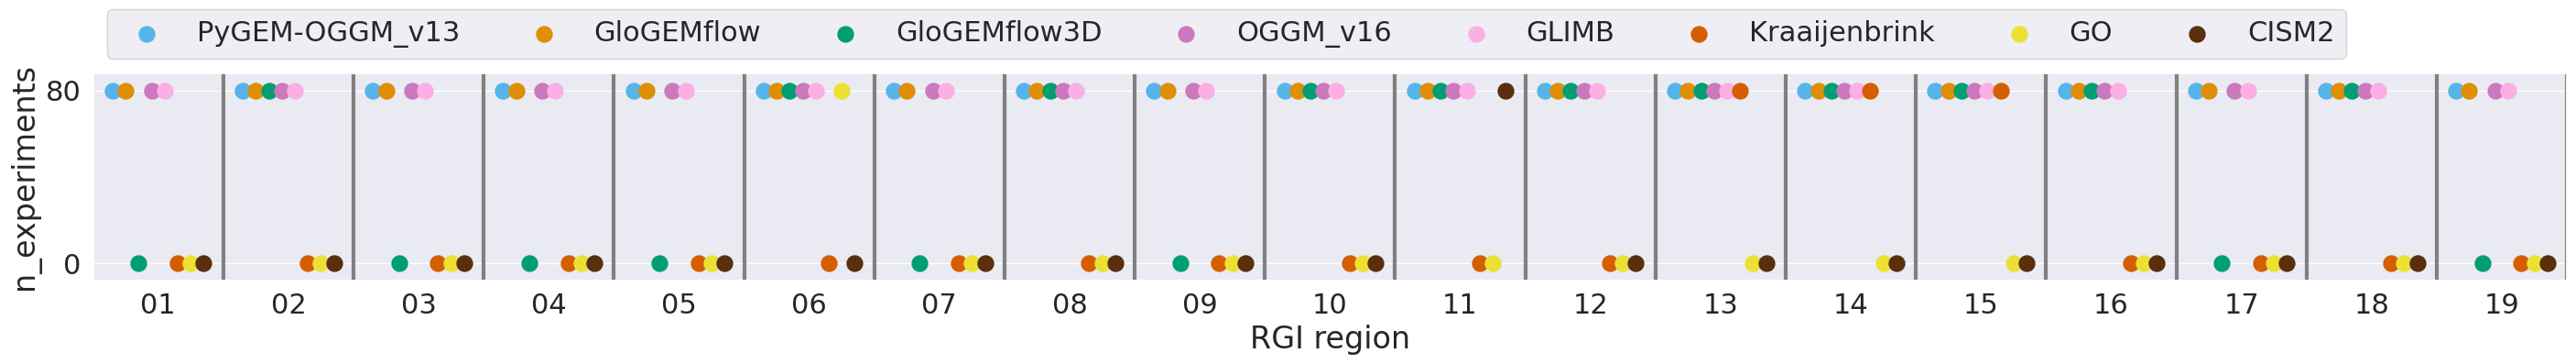

In [58]:
pd_regional_sum_initial_models = ds_reg_models.sel(simulation_year=0).to_dataframe()
pd_regional_sum_initial_models = pd_regional_sum_initial_models.reset_index()
#pd_reg_models = pd_reg_models.dropna()
pd_reg_models_count = pd_regional_sum_initial_models.groupby(['rgi_reg', 'model_author'])['volume_m3'].count().reset_index()
pd_reg_models_count = pd_reg_models_count.rename(columns={'volume_m3':'n_experiments'})
#pd_reg_models_count.loc[pd_reg_models_count.n_experiments == 80].groupby('rgi_reg').count()['model_author']
plt.figure(figsize=(30,4.5))
sns.pointplot( x='rgi_reg', y= 'n_experiments', hue='model_author',
             data=pd_reg_models_count,  #stacked=True,#ax=ax,
            hue_order=hue_order, #stacked =True,
            palette=pal_models, dodge=0.7, join = False,
             markers='o', scale=1.5)
ax = plt.gca()
h,l = ax.get_legend_handles_labels()
ax.legend(h, l, ncol=9, loc='lower left', bbox_to_anchor=(0,1))
for f in np.arange(0.5,19,1):
    ax.axvline(f, color= 'grey', ls='-', lw=3)
ax.set_yticks([0,80])
ax.set_ylim([-8,88])
plt.tight_layout()
ax.set_xlabel('RGI region')
plt.savefig(f'figures/plots_glacier_model_init_data/0_glacierMIP3_n_experiments_{DATE}.png')

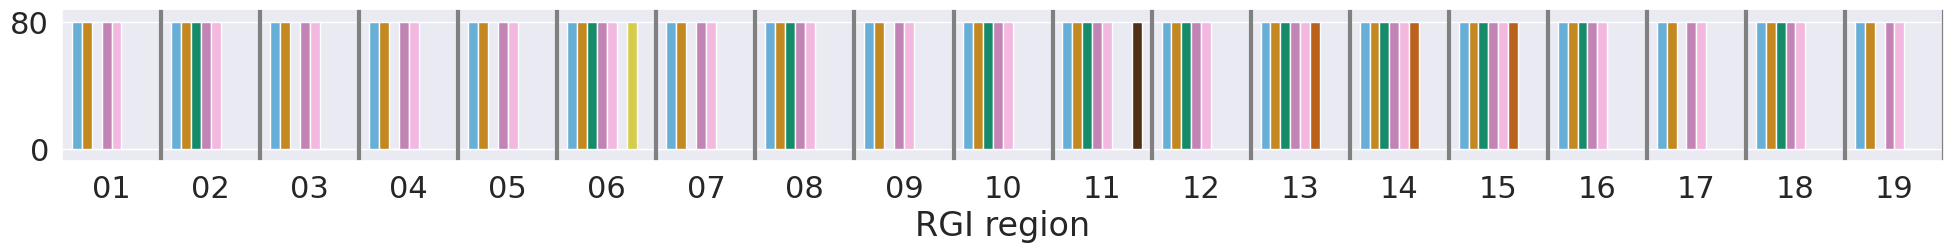

In [59]:
pd_regional_sum_initial_models = ds_reg_models.sel(simulation_year=0).to_dataframe()
pd_regional_sum_initial_models = pd_regional_sum_initial_models.reset_index()
#pd_reg_models = pd_reg_models.dropna()
pd_reg_models_count = pd_regional_sum_initial_models.groupby(['rgi_reg', 'model_author'])['volume_m3'].count().reset_index()
pd_reg_models_count = pd_reg_models_count.rename(columns={'volume_m3':'n_experiments'})
#pd_reg_models_count.loc[pd_reg_models_count.n_experiments == 80].groupby('rgi_reg').count()['model_author']
plt.figure(figsize=(20,3))
plt.rc('font', size=22)     

sns.barplot( x='rgi_reg', y= 'n_experiments', hue='model_author',
             data=pd_reg_models_count,  #stacked=True,#ax=ax,
            hue_order=hue_order,# stacked =True,
            palette=pal_models) #dodge=0.7, join = False,
             #markers='o', scale=1.5)
ax = plt.gca()
h,l = ax.get_legend_handles_labels()
leg = ax.legend(h, l, ncol=9, loc='lower left', bbox_to_anchor=(0,1))
leg.remove()
for f in np.arange(0.5,19,1):
    ax.axvline(f, color= 'grey', ls='-', lw=3)
plt.ylabel('')
ax.set_yticks([0,80])
ax.set_ylim([-8,88])
plt.tight_layout()
ax.set_xlabel('RGI region')
plt.savefig(f'figures/plots_glacier_model_init_data/0_glacierMIP3_n_experiments_no_legend_{DATE}.png')

**create overview for presentation**

In [45]:
pd_regional_sum_initial_models = ds_reg_models.sel(simulation_year=0).to_dataframe()
pd_regional_sum_initial_models = pd_regional_sum_initial_models.reset_index()
#pd_reg_models = pd_reg_models.dropna()
pd_reg_models_count = pd_regional_sum_initial_models.groupby(['rgi_reg', 'model_author'])['volume_m3'].count().reset_index()
pd_reg_models_count = pd_reg_models_count.rename(columns={'volume_m3':'n_experiments'})
total_count= pd_reg_models_count.groupby('model_author').sum().drop(columns='rgi_reg')

In [46]:
total_count

,n_experiments
model_author,
CISM2,80
GLIMB,1520
GO,80
GloGEMflow,1520
GloGEMflow3D,880
Kraaijenbrink,240
OGGM_v16,1520
PyGEM-OGGM_v13,1520


In [47]:
global_models = total_count.where(total_count== 1520).dropna().index.values
print(f'glacier models that are globally available for all experiments: n={len(global_models)}\n({global_models})')


glacier models that are globally available for all experiments: n=4
(['GLIMB' 'GloGEMflow' 'OGGM_v16' 'PyGEM-OGGM_v13'])


In [49]:
one_region_models = total_count.where(total_count== 80).dropna().index.values
one_region_models

array(['CISM2', 'GO'], dtype=object)

In [50]:
total_count

,n_experiments
model_author,
CISM2,80
GLIMB,1520
GO,80
GloGEMflow,1520
GloGEMflow3D,880
Kraaijenbrink,240
OGGM_v16,1520
PyGEM-OGGM_v13,1520


#### Check initial states to see whether the scaling worked correctly

In [51]:
for rgi_reg in rgi_regs: 
    pd_regional_sum_initial_models.loc[pd_regional_sum_initial_models.loc[pd_regional_sum_initial_models.rgi_reg== rgi_reg].index,
                                  'rgi_area_m2'] = rgidf_dict[rgi_reg]['Area'].sum()*1e6
    pd_regional_sum_initial_models.loc[pd_regional_sum_initial_models.loc[pd_regional_sum_initial_models.rgi_reg== rgi_reg].index,
                                  'itmix_vol_m3'] = df_itmix.loc[rgidf_dict[rgi_reg].index.values]['vol_itmix_m3'].sum()
pd_regional_sum_initial_models['perc_rgi_area'] = 100 * pd_regional_sum_initial_models['area_m2']/pd_regional_sum_initial_models['rgi_area_m2']
pd_regional_sum_initial_models['perc_itmix_vol'] = 100 * pd_regional_sum_initial_models['volume_m3']/pd_regional_sum_initial_models['itmix_vol_m3']

pd_regional_sum_initial_models = pd_regional_sum_initial_models.dropna()


np.testing.assert_allclose(pd_regional_sum_initial_models['perc_rgi_area'], 100)
np.testing.assert_allclose(pd_regional_sum_initial_models['perc_itmix_vol'], 100)



### just look at it before having done the scaling to 100% (kind of a sanity test, at least for those models that did not do an internal scaling already)

In [60]:
# without scaling
#out_path = f'/home/www/lschuster/glacierMIP3_analysis/glacierMIP3_{DATE}_models_all_rgi_regions_sum.nc'
out_path2 = f'../data/GMIP3_reg_glacier_model_data/glacierMIP3_{DATE}_models_all_rgi_regions_sum.nc'

ds_reg_models = xr.open_dataset(out_path2)

pd_regional_sum_initial_models = ds_reg_models.sel(simulation_year=0).to_dataframe()
pd_regional_sum_initial_models = pd_regional_sum_initial_models.reset_index()
#pd_reg_models = pd_reg_models.dropna()
pd_reg_models_count = pd_regional_sum_initial_models.groupby(['rgi_reg', 'model_author'])['volume_m3'].count().reset_index()
pd_reg_models_count = pd_reg_models_count.rename(columns={'volume_m3':'n_experiments'})

for rgi_reg in rgi_regs: #rgi_regs:
    pd_regional_sum_initial_models.loc[pd_regional_sum_initial_models.loc[pd_regional_sum_initial_models.rgi_reg== rgi_reg].index,
                                  'rgi_area_m2'] = rgidf_dict[rgi_reg]['Area'].sum()*1e6
    pd_regional_sum_initial_models.loc[pd_regional_sum_initial_models.loc[pd_regional_sum_initial_models.rgi_reg== rgi_reg].index,
                                  'itmix_vol_m3'] = df_itmix.loc[rgidf_dict[rgi_reg].index.values]['vol_itmix_m3'].sum()
pd_regional_sum_initial_models['perc_rgi_area'] = 100 * pd_regional_sum_initial_models['area_m2']/pd_regional_sum_initial_models['rgi_area_m2']
pd_regional_sum_initial_models['perc_itmix_vol'] = 100 * pd_regional_sum_initial_models['volume_m3']/pd_regional_sum_initial_models['itmix_vol_m3']

pd_regional_sum_initial_models = pd_regional_sum_initial_models.dropna()

/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/users/lschuster/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

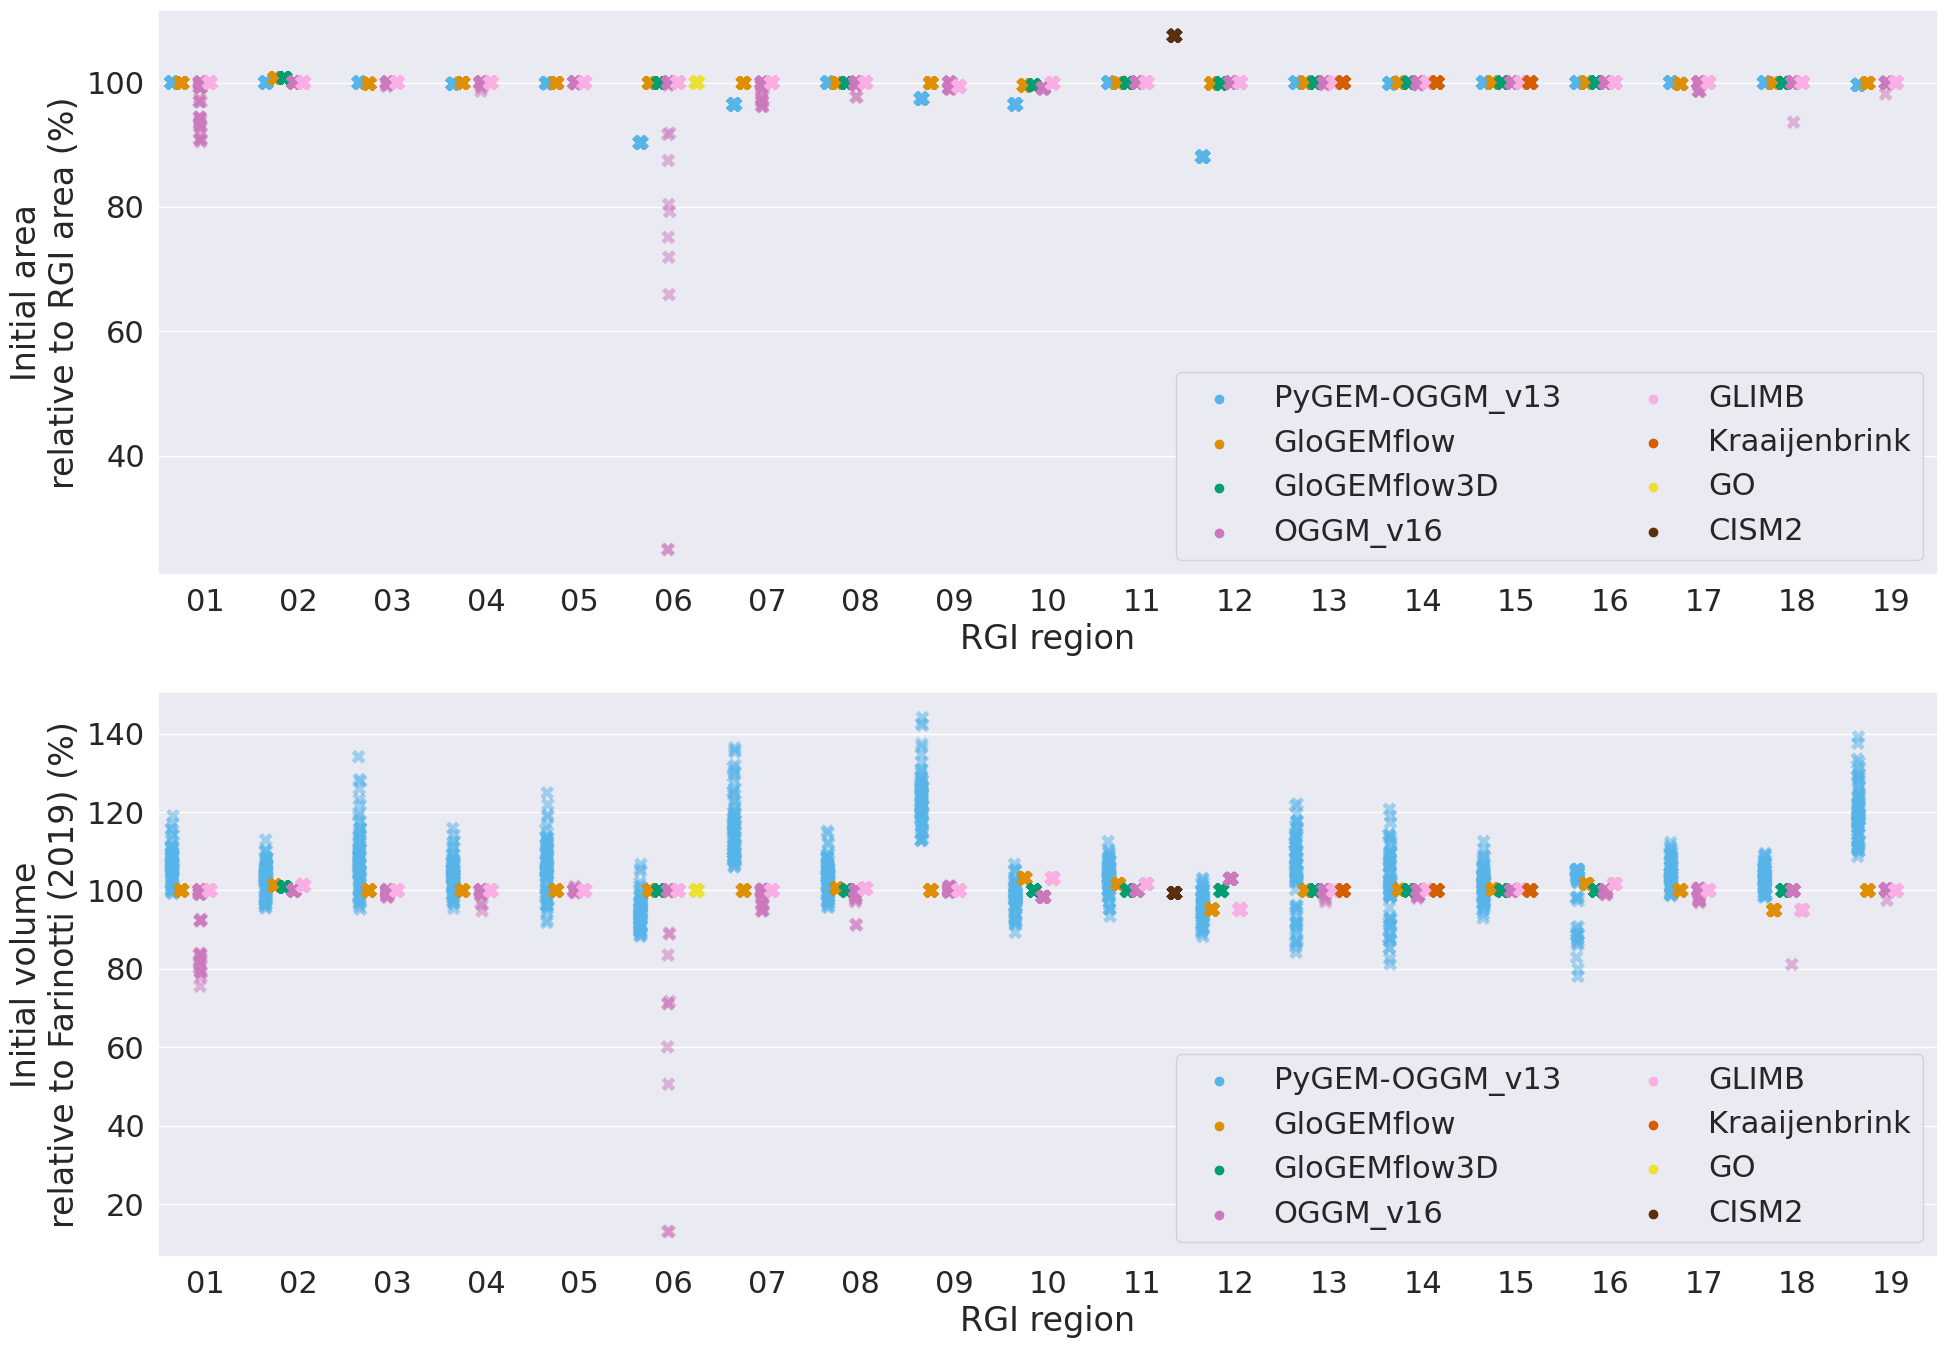

In [62]:
from matplotlib.lines import Line2D

sns.set(font_scale=2)
#ssp_cols = sns.color_palette(['silver', 'deepskyblue', 'orange', 'red'])
for anonym in ['']:
    fig, axs = plt.subplots(2,1, figsize=(20,14))
    #plt.suptitle(')

    sns.stripplot(data=pd_regional_sum_initial_models, #.loc['hist' in pd_regional_sum_initial_models.period_ssp],
                                hue_order=hue_order,
                  palette = pal_models,
                #col_wrap=1,
                #col_order=col_order,
                #aspect=2,
                  order = rgi_regs,
                x='rgi_reg', y='perc_rgi_area',
                ax = axs[0],
                dodge=True,
                  alpha = 0.5,
                hue='model_author', #palette=ssp_cols,
                #kind='strip',
                #whis = [5,95], #hue_order = ['2040', '2100'],
                        linewidth=0.5,
                size=10,
                  marker='X',
                edgecolor='None',
                # = False,
                #col='ssp',
                #saturation=0.7,# aspect=1.6, #order = ['var_an_cycle'],
                        #capprops={'color':'grey', 'alpha':0.7},
                        #whiskerprops={'color':'grey', 'alpha':0.7}
               )

    #axs[0].set_ylim([70,130])
    handles, labels = axs[0].get_legend_handles_labels()
    if anonym:
        axs[0].legend(handles, hue_order_anonymous, ncol=2)
    else:
        axs[0].legend(ncol=2)

    axs[0].set_ylabel('Initial area\nrelative to RGI area (%)')
    axs[0].set_xlabel('RGI region')

    sns.stripplot(data=pd_regional_sum_initial_models, #.loc[pd_regional_sum_initial_models.ssp == 'hist'],
                                hue_order=hue_order,
                  palette = pal_models,
                #col_wrap=1,
                #col_order=col_order,
                #aspect=2,
                  order = rgi_regs,
                x='rgi_reg', y='perc_itmix_vol',
                ax = axs[1],
                dodge=True,
                hue='model_author', #palette=ssp_cols,
                #kind='strip',
                #whis = [5,95], #hue_order = ['2040', '2100'],
                        linewidth=0.5,
                size=10,
                  marker='X',
                  alpha = 0.5,
                edgecolor='None',
                # = False,
                #col='ssp',
                #saturation=0.7,# aspect=1.6, #order = ['var_an_cycle'],
                        #capprops={'color':'grey', 'alpha':0.7},
                        #whiskerprops={'color':'grey', 'alpha':0.7}
               )  
    handles, labels = axs[1].get_legend_handles_labels()

    if anonym:
        axs[1].legend(handles, hue_order_anonymous, ncol=2)
    else:
        axs[1].legend(ncol=2)
    axs[1].set_ylabel('Initial volume\nrelative to Farinotti (2019) (%)')
    axs[1].set_xlabel('RGI region')
    plt.tight_layout()
    plt.savefig(f'figures/plots_glacier_model_init_data/0_glacierMIP3_initial_state_before_scaling_{DATE}{anonym}.png')

- In RGI region 06, OGGM has many missing glaciers and the relative glacier area and volume even after filling is very small. The reason is the growing glaciers that grow out of the boundary for cold conditions. Something to consider when comparing results between glacier models.
- Also: PyGEM-OGGM often does not perfectly match the initial volume. Specificall y iportant maybe in RGI region 09 and 19. Can this explain some of the relative volume differences?

In [64]:


# this is not working for all..
#np.testing.assert_allclose(pd_regional_sum_initial_models['perc_itmix_vol'], 100, rtol = 0.5)
#np.testing.assert_allclose(pd_regional_sum_initial_models['perc_rgi_area'], 100, rtol =0.2)

